In [1]:
## importing libraries
import pandas as pd # our main data management package
import matplotlib.pyplot as plt # our main display package
import string # used for preprocessing
import re # used for preprocessing
import numpy as np # used for managing NaNs
from wordcloud import WordCloud,ImageColorGenerator
from nltk.stem import PorterStemmer
from PIL import Image
import seaborn as sns
import urllib
import requests
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
import gensim
from gensim.models.coherencemodel import CoherenceModel
from nltk.tokenize import word_tokenize
import gensim.corpora as corpora
from pprint import pprint
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize # our tokenizer
from nltk.corpus import stopwords # used for preprocessing
from nltk.stem import WordNetLemmatizer # used for preprocessing
from collections import Counter
from textblob import TextBlob
from yellowbrick.text import FreqDistVisualizer
stopword = stopwords.words('english')
nltk.stem.SnowballStemmer('english')
ps = nltk.PorterStemmer()
wn = nltk.WordNetLemmatizer()

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from skle

In [2]:
df = pd.read_csv('vaccination_tweets.csv')

## 1. Exploratory Data Analysis

### 1.1. Number of words

In [3]:
df['word_count'] = df['text'].str.encode('utf-8').apply(lambda x: len(str(x).split(" ")))
df[['text','word_count']].head()

,text,word_count
0,Same folks said daikon paste could treat a cyt...,12
1,While the world has been on the wrong side of ...,21
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,15
3,"Facts are immutable, Senator, even when you're...",20
4,Explain to me again why we need a vaccine @Bor...,14


### 1.2. Number of characters

In [4]:
df['char_count'] = df['text'].str.len()
df[['text','char_count']].head()

,text,char_count
0,Same folks said daikon paste could treat a cyt...,97
1,While the world has been on the wrong side of ...,140
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,140
3,"Facts are immutable, Senator, even when you're...",140
4,Explain to me again why we need a vaccine @Bor...,135


### 1.3. Average word length

In [5]:
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))

df['avg_word'] = df['text'].apply(lambda x: avg_word(x))
df[['text','avg_word']].head()

,text,avg_word
0,Same folks said daikon paste could treat a cyt...,7.166667
1,While the world has been on the wrong side of ...,5.714286
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,8.400000
3,"Facts are immutable, Senator, even when you're...",6.050000
4,Explain to me again why we need a vaccine @Bor...,8.714286


### 1.4. Number of StopWords

In [6]:
df['num_stopwords'] = df['text'].apply(lambda x: len([x for x in x.split() if x in stopword]))
df[['text','num_stopwords']].head()

,text,num_stopwords
0,Same folks said daikon paste could treat a cyt...,1
1,While the world has been on the wrong side of ...,8
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,2
3,"Facts are immutable, Senator, even when you're...",6
4,Explain to me again why we need a vaccine @Bor...,6


### 1.5. Number of special characters, numbers & uppercase words

In [7]:
df['numerics'] = df['text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
df['upper'] = df['text'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
df['hashtags'] = df['text'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
df[['text', 'numerics', 'upper', 'hashtags']].head(10)

,text,numerics,upper,hashtags
0,Same folks said daikon paste could treat a cyt...,0,0,1
1,While the world has been on the wrong side of ...,0,0,0
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,0,0,6
3,"Facts are immutable, Senator, even when you're...",0,0,0
4,Explain to me again why we need a vaccine @Bor...,0,0,2
5,Does anyone have any useful advice/guidance fo...,0,1,0
6,it is a bit sad to claim the fame for success ...,0,2,1
7,There have not been many bright days in 2020 b...,1,0,2
8,Covid vaccine; You getting it?\n\n #CovidVacci...,0,0,4
9,#CovidVaccine \n\nStates will start getting #C...,0,2,7


## 2. Basic Pre-processing

### 2.1. Lower case

### 2.2. Removing Punctuation

In [8]:
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

### 2.3. Common word removal

In [9]:
freq = pd.Series(' '.join(df['text']).split()).value_counts()[:20]
freq = list(freq.index)
freq = [x for x in freq if not x.startswith('#')]
freq

['the',
 'to',
 'of',
 'vaccine',
 'in',
 'and',
 'a',
 'for',
 'is',
 'I',
 'first',
 'The',
 'on',
 'my',
 'have',
 'with',
 'be']

### 2.4. Removal of Stop Words

In [10]:
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text

### 2.5. Rare words removal (noise)

In [11]:
rare_freq = pd.Series(' '.join(df['text']).split()).value_counts()[-20:]
rare_freq

free-of-charge             1
https://t.co/d3koIEm6vU    1
Phenomenal                 1
w!                         1
data"                      1
OUT                        1
GET                        1
https://t.co/RO2IsNOOOU    1
Accordi…                   1
@ImperialNHLI              1
https://t.co/1Mbl68ICIy    1
staff…                     1
hospital's                 1
https://t.co/EYXfQfeUVq    1
combating                  1
https://t.co/uWiv1SypWg    1
#AFP                       1
https://t.co/mv47AfjSbU    1
https://t.co/c71uwfMIvW    1
busy                       1
dtype: int64

### 2.6. Tokenization

In [12]:
def tokenization(text):
    text = re.split('\W+', text)
    return text

### 2.7. Stemming

In [13]:
def stemming(text):
    text = [ps.stem(word) for word in text]
    return text

### 2.8. Lemmatization

In [14]:
def lemmatizer(text):
    text = [wn.lemmatize(word) for word in text]
    return text

### 2.9. Putting it all together

In [15]:
df['clean_text'] = df['text'].apply(lambda x: remove_punct(x))
df['text_tokenized'] = df['clean_text'].apply(lambda x: tokenization(x.lower()))
df['text_nonstop'] = df['text_tokenized'].apply(lambda x: remove_stopwords(x))
df['text_stemmed'] = df['text_nonstop'].apply(lambda x: stemming(x))
df['text_lemmatized'] = df['text_nonstop'].apply(lambda x: lemmatizer(x))

# For future processing needed: string formatted clean text
str_lemmatized = []
for i in df['text_lemmatized']:
    str_lemmatized.append(' '.join(i))
    
df['str_lemmatized'] = str_lemmatized
df.head(5)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,...,avg_word,num_stopwords,numerics,upper,clean_text,text_tokenized,text_nonstop,text_stemmed,text_lemmatized,str_lemmatized
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,...,7.166667,1,0,0,Same folks said daikon paste could treat a cyt...,"[same, folks, said, daikon, paste, could, trea...","[folks, said, daikon, paste, could, treat, cyt...","[folk, said, daikon, past, could, treat, cytok...","[folk, said, daikon, paste, could, treat, cyto...",folk said daikon paste could treat cytokine st...
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,...,5.714286,8,0,0,While the world has been on the wrong side of ...,"[while, the, world, has, been, on, the, wrong,...","[world, wrong, side, history, year, hopefully,...","[world, wrong, side, histori, year, hope, bigg...","[world, wrong, side, history, year, hopefully,...",world wrong side history year hopefully bigges...
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,...,8.400000,2,0,0,coronavirus SputnikV AstraZeneca PfizerBioNTec...,"[coronavirus, sputnikv, astrazeneca, pfizerbio...","[coronavirus, sputnikv, astrazeneca, pfizerbio...","[coronaviru, sputnikv, astrazeneca, pfizerbion...","[coronavirus, sputnikv, astrazeneca, pfizerbio...",coronavirus sputnikv astrazeneca pfizerbiontec...
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,...,6.050000,6,0,0,Facts are immutable Senator even when youre no...,"[facts, are, immutable, senator, even, when, y...","[facts, immutable, senator, even, youre, ethic...","[fact, immut, senat, even, your, ethic, sturdi...","[fact, immutable, senator, even, youre, ethica...",fact immutable senator even youre ethically st...
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,...,8.714286,6,0,0,Explain to me again why we need a vaccine Bori...,"[explain, to, me, again, why, we, need, a, vac...","[explain, need, vaccine, borisjohnson, matthan...","[explain, need, vaccin, borisjohnson, matthanc...","[explain, need, vaccine, borisjohnson, matthan...",explain need vaccine borisjohnson matthancock ...


>

## 3. Text-data plotting

### 3.1. Plotting the most frequent hashtags with a bar-chart

In [16]:
def hashtag_extract(x):
    hashtags = []
    
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

HT_regular = hashtag_extract(df['text'])
HT_regular = sum(HT_regular,[])

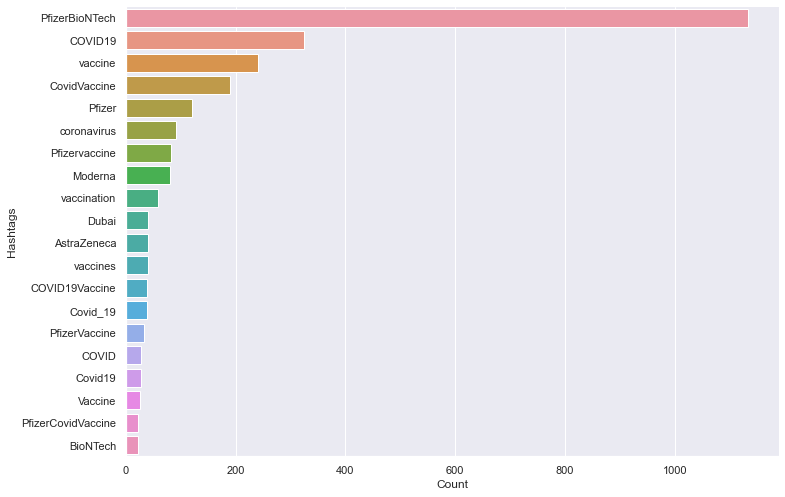

In [73]:
word_freq_regular = nltk.FreqDist(HT_regular)
df_positive = pd.DataFrame({'Hashtags':list(word_freq_regular.keys()),'Count':list(word_freq_regular.values())})
df_positive_plot = df_positive.nlargest(20,columns='Count')
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(data=df_positive_plot, y='Hashtags', x='Count')
sns.despine()

### 3.2 WordCloud

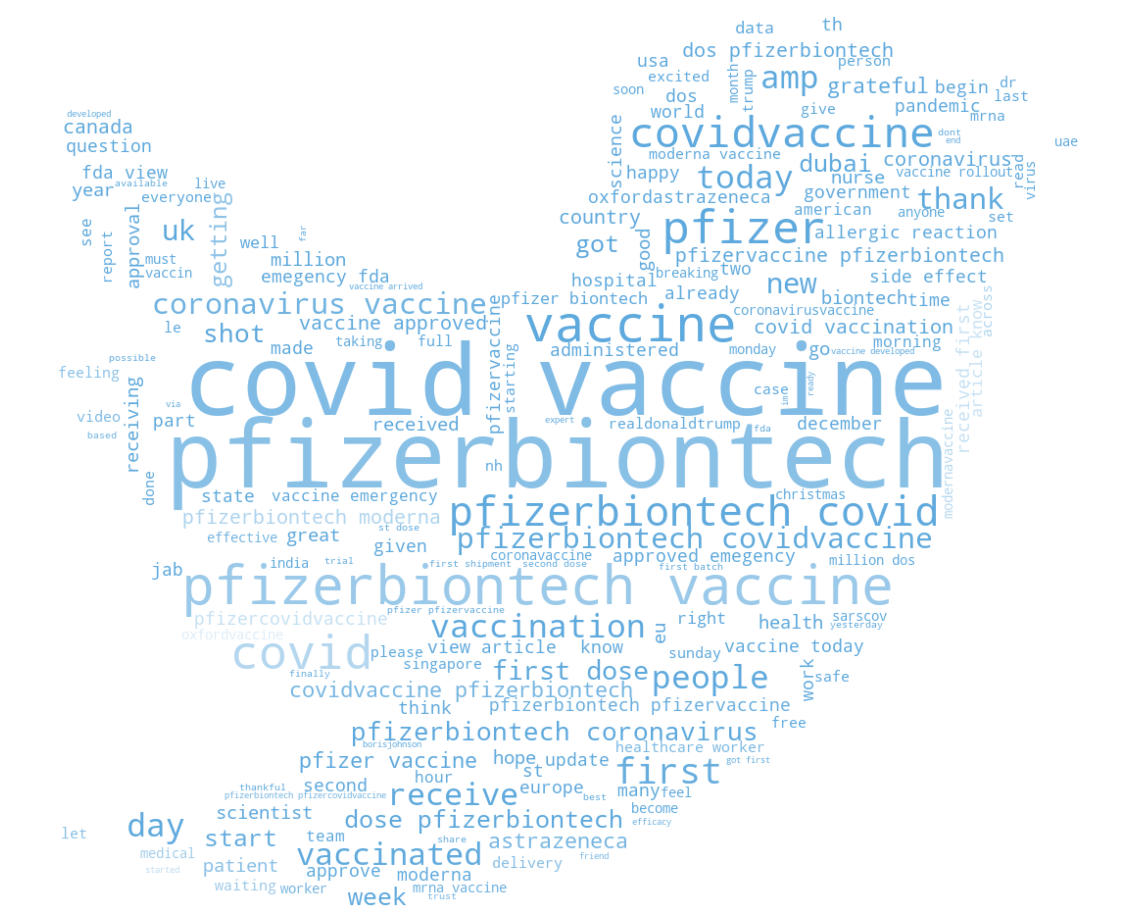

In [17]:
def WordCloud_text(df):
    
    all_words_positive = ' '.join(text for text in df)
    all_words_positive = all_words_positive.split()
    words_to_remove = ['may', 'used', 'much', 'likely', 'still', 'use', 'come', 'going', 'keep', 'long', 'enough', 'said', 
                       'need', 'make', 'say', 'way', 'lot', 'yet', 'working', 'every', 'want', 'take', 'callled', 'thing', 
                       'although', 'according', 'around', 'one', 'might', 'even']
    all_words_positive = [word for word in all_words_positive if word not in words_to_remove]
    all_words_positive = ' '.join(text for text in all_words_positive)

    # combining the image with the dataset
    Mask = np.array(Image.open(requests.get('http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png', stream=True).raw))

    # We use the ImageColorGenerator library from Wordcloud 
    # Here we take the color of the image and impose it over our wordcloud
    image_colors = ImageColorGenerator(Mask)

    # Now we use the WordCloud function from the wordcloud library 
    wc = WordCloud(background_color='white', height=1500, width=4000,mask=Mask).generate(all_words_positive)

    # Size of the image generated 
    plt.figure(figsize=(20,20))

    # Here we recolor the words from the dataset to the image's color
    # recolor just recolors the default colors to the image's blue color
    # interpolation is used to smooth the image generated 
    plt.imshow(wc.recolor(color_func=image_colors),interpolation="hamming")

    plt.axis('off')
    plt.show()
    
WordCloud_text(df['str_lemmatized'])

### 3.3 N-grams

In [39]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df['clean_text'], 20)
for word, freq in common_words:
    print(word, freq)

covid vaccine 342
pfizerbiontech vaccine 269
pfizerbiontech covid 156
pfizerbiontech covidvaccine 78
coronavirus vaccine 76
pfizerbiontech coronavirus 62
dose pfizerbiontech 58
covidvaccine pfizerbiontech 47
covid pfizerbiontech 46
pfizer vaccine 46
pfizervaccine pfizerbiontech 43
covid vaccines 41
pfizerbiontech moderna 40
doses pfizerbiontech 39
vaccine approved 38
vaccine pfizerbiontech 37
emergency use 36
pfizer pfizerbiontech 36
covid vaccination 35
pfizerbiontech pfizervaccine 33


### 3.4 Bar plot of source of sent Tweet

In [48]:
df['source'].value_counts()

Twitter for iPhone                 758
Twitter Web App                    744
Twitter for Android                524
TweetDeck                          172
Twitter for iPad                    73
Buffer                              16
Instagram                           16
Hootsuite Inc.                       9
Nonli                                6
SocialFlow                           5
Microsoft Power Platform             5
24liveblog                           4
LinkedIn                             4
Echobox                              2
Twitter Media Studio                 2
Twitter Media Studio - LiveCut       1
EastMojo                             1
Twitter for Mac                      1
ThreadReaderApp                      1
Socialbakers                         1
Tweetbot for Mac                     1
Sendible                             1
Falcon Social Media Management       1
IFTTT                                1
Publer                               1
Name: source, dtype: int6

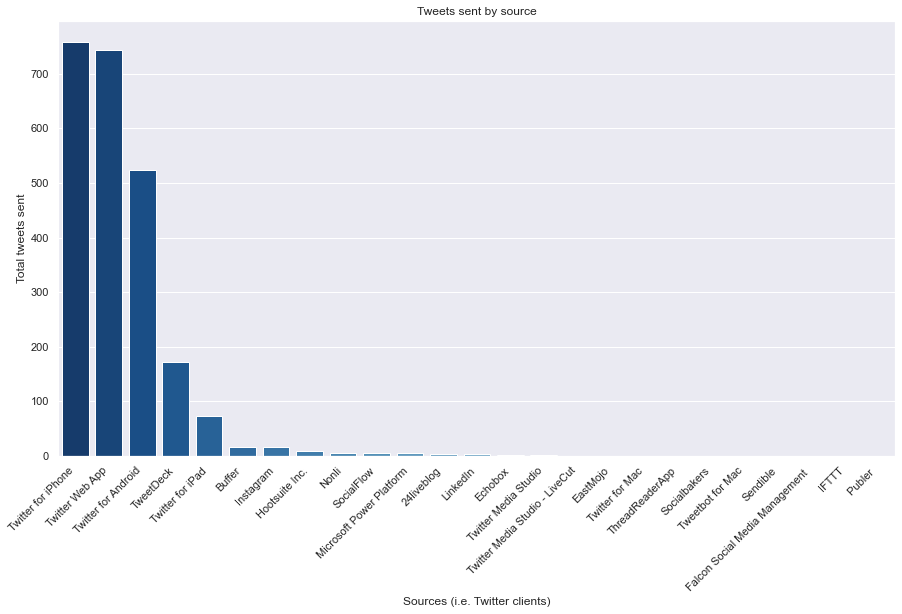

In [49]:
# set the figure size
plt.figure(figsize=(15,8))

# create a countplot, ordered by count
sns.countplot(x='source', data=df, palette = 'Blues_r' , order = df['source'].value_counts().index)

# rotate the ticks for better readability
plt.xticks(rotation=45, fontsize='11', horizontalalignment='right')

# set the labels and title
plt.xlabel('Sources (i.e. Twitter clients)')
plt.ylabel('Total tweets sent')
plt.title('Tweets sent by source');

### 3.5 Average Length of Tweets

In [130]:
avg_length = df[['word_count']]
avg_length.describe()

,word_count
count,2351.000000
mean,16.730328
std,4.284213
min,2.000000
25%,14.000000
50%,17.000000
75%,20.000000
max,28.000000


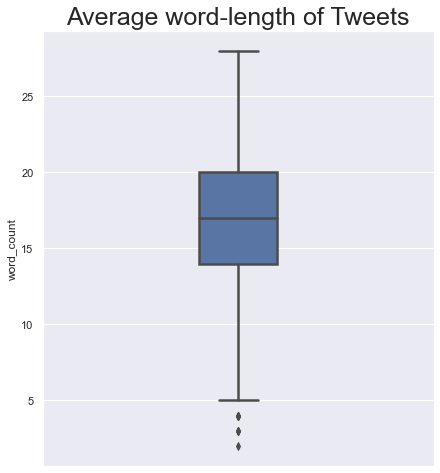

In [139]:
sns.set(rc={'figure.figsize':(7,8)})
sns.boxplot(y=df["word_count"], width=0.2, linewidth=2.5).set_title("Average word-length of Tweets", size = 25);
plt.show()

### 3.6 Overview of Retweet-Distribution

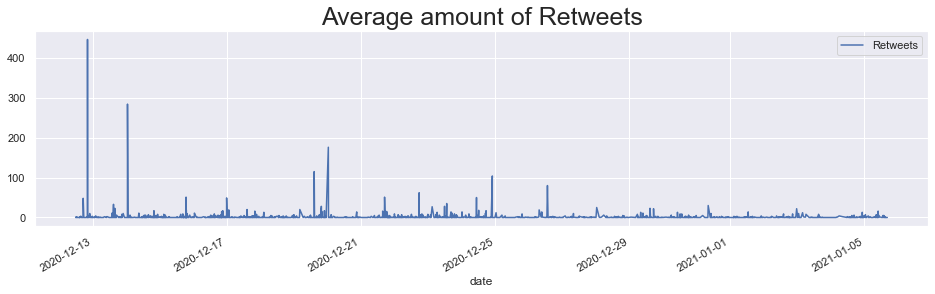

In [141]:
tret = pd.Series(data=df['retweets'].values, index=df['date'])
tret.plot(figsize=(16,4), label="Retweets", legend=True).set_title("Average amount of Retweets", size = 25);

In [123]:
# max retweeted Tweet
# Charles Adler --- > Host of "CharlesAdlerTonight" Global News Radio Network
df[['retweets', 'text', 'date', 'id', 'user_name']].sort_values(by=['retweets'], ascending = False).head(1)

,retweets,text,date,id,user_name
3,446,"Facts are immutable, Senator, even when you're...",2020-12-12 20:23:59,1337855739918835717,Charles Adler


## 4. Sentiment Analysis

In [145]:
def clean_tweet(tweet):
    # remove special characters, links from tweets
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def analize_sentiment(tweet):
    # predict the sentiment of a tweet using textblob
    analysis = TextBlob(clean_tweet(tweet))
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1
df['sentiment'] = np.array([analize_sentiment(tweet) for tweet in df['clean_text']])
df[['clean_text', 'sentiment']].head(10)

,clean_text,sentiment
0,Same folks said daikon paste could treat a cyt...,0
1,While the world has been on the wrong side of ...,-1
2,coronavirus SputnikV AstraZeneca PfizerBioNTec...,0
3,Facts are immutable Senator even when youre no...,-1
4,Explain to me again why we need a vaccine Bori...,0
5,Does anyone have any useful adviceguidance for...,1
6,it is a bit sad to claim the fame for success ...,-1
7,There have not been many bright days in but h...,1
8,Covid vaccine You getting it\n\n CovidVaccine ...,0
9,CovidVaccine \n\nStates will start getting COV...,0


In [146]:
# construct lists with classified tweets
pos_tweets = [ tweet for index, tweet in enumerate(df['text']) if df['sentiment'][index] > 0]
neu_tweets = [ tweet for index, tweet in enumerate(df['text']) if df['sentiment'][index] == 0]
neg_tweets = [ tweet for index, tweet in enumerate(df['text']) if df['sentiment'][index] < 0]

# print percentages
print("Percentage of positive tweets: {}%".format(len(pos_tweets)*100/len(df['text'])))
print("Percentage of neutral tweets: {}%".format(len(neu_tweets)*100/len(df['text'])))
print("Percentage of negative tweets: {}%".format(len(neg_tweets)*100/len(df['text'])))

Percentage of positive tweets: 45.2573373032752%
Percentage of neutral tweets: 44.83198638877074%
Percentage of negative tweets: 9.910676307954063%


In [163]:
plt.figure(figsize=(10,8))
df = df.replace({'sentiment': {-1: 'negative', 0: 'neutral', 1: 'positive'}})
x=df['sentiment'].value_counts().index
y=df['sentiment'].value_counts().values

<Figure size 720x576 with 0 Axes>

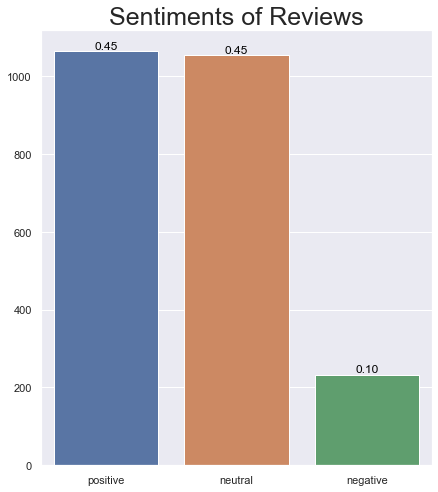

In [165]:
ax = sns.barplot(x, y, data=df)

total = float(len(df))

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height, '{:1.2f}'.format(height/total), 
            fontsize=12, color='black', ha='center', va='bottom')

plt.title('Sentiments of Reviews', size = 25)
plt.show()